In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.datasets.emnist_lines_dataset import EmnistLinesDataset
from text_recognizer.networks import transformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's look at the stuff we need

In [5]:
# Loss function and accuracy function that ignore padding

from text_recognizer.models.util import sparse_categorical_accuracy_ignoring_padding, sparse_categorical_crossentropy_ignoring_padding

y_true = tf.constant([1, 2, 0, 0])
y_pred = tf.constant([
    [0, 100., 0],  # correct
    [0, 0, 100.],  # correct,
    [0, 0, 100.],  # incorrect (but it doesn't matter)
    [0, 0, 100.],  # incorrect (but it doesn't matter)
])
print(sparse_categorical_crossentropy_ignoring_padding(y_true, y_pred, padding_label=0))
print(sparse_categorical_accuracy_ignoring_padding(y_true, y_pred, padding_label=0))

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor([1. 1. 1. 1.], shape=(4,), dtype=float32)


In [7]:
# Note that you can debug by putting a `breakpoint()` in your function code:

def sparse_categorical_crossentropy_ignoring_padding_for_debug(
    y_true: tf.Tensor, y_pred: tf.Tensor, padding_label: int
) -> tf.Tensor:
    """Sparse categorical crossentropy that ignores padding."""
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, padding_label), tf.float32)
    loss = tf.multiply(loss, mask)
    breakpoint()
    return tf.reduce_mean(loss)


sparse_categorical_crossentropy_ignoring_padding_for_debug(y_true, y_pred, padding_label=0)

> <ipython-input-7-bc78918e318b>(11)sparse_categorical_crossentropy_ignoring_padding_for_debug()
-> return tf.reduce_mean(loss)


(Pdb)  c


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

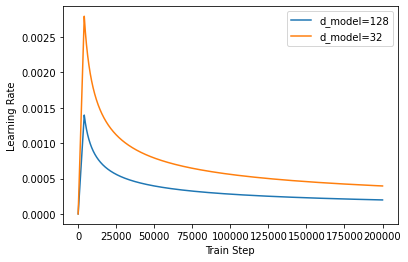

In [8]:
# The learning rate scheduler is more complicated than usual...

from text_recognizer.models.util import CustomSchedule

learning_rate = CustomSchedule(d_model=128)
plt.plot(learning_rate(tf.range(200000, dtype=tf.float32)), label='d_model=128')

learning_rate = CustomSchedule(d_model=32)
plt.plot(learning_rate(tf.range(200000, dtype=tf.float32)), label='d_model=32')

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.legend()

In [9]:
learning_rate = CustomSchedule(d_model=32)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

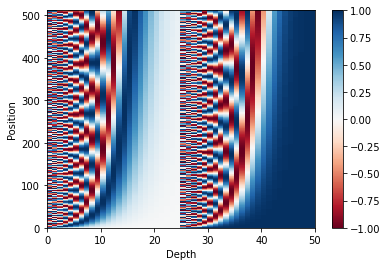

In [10]:
# Let's look at how positional encoding looks like
# For more info, see https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

from text_recognizer.networks.transformer.positional_encoding import PositionalEncoding

sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 50))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Now let's get something going on no-overlap short sequences

In [11]:
dataset = EmnistLinesDataset(max_length=8, min_overlap=0, max_overlap=0, num_train=100000, num_test=10000, with_start_and_end_labels=True)
dataset.load_or_generate_data()
print(dataset)
print(dataset.x_train.shape, dataset.y_train.shape)
print(dataset.x_test.shape, dataset.y_test.shape)

EmnistLinesDataset loading data from HDF5...
EMNIST Lines Dataset
Max length: 8
Min overlap: 0
Max overlap: 0
Num classes: 82
Input shape: (28, 224)
Train: (100000, 28, 224) (100000, 10)
Test: (10000, 28, 224) (10000, 10)

(100000, 28, 224) (100000, 10)
(10000, 28, 224) (10000, 10)


In [12]:
dataset.y_train, dataset.y_train.shape

(array([[80., 55., 50., ..., 79., 79., 79.],
        [80., 36., 49., ..., 79., 79., 79.],
        [80., 55., 50., ..., 81., 79., 79.],
        ...,
        [80., 25., 36., ..., 79., 79., 79.],
        [80., 43., 50., ..., 81., 79., 79.],
        [80., 44., 49., ..., 54., 81., 79.]]),
 (100000, 10))

In [13]:
from text_recognizer.datasets.dataset_sequence import DatasetSequence

def format_batch(x, y):
    """
    Inputs are x and y up to the last character.
    Outputs are y from first character (shifted).
    """
    return [x, y[:, :-1]], y[:, 1:]

batch_size = 256

train_data = DatasetSequence(dataset.x_train, dataset.y_train, batch_size=batch_size, format_fn=format_batch)
test_data = DatasetSequence(dataset.x_test, dataset.y_test, batch_size=batch_size, format_fn=format_batch)

train_data[0]

([array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
         

## Now we're ready to define our model

In [14]:
from text_recognizer.networks.transformer.main import transformer

model = transformer(
    image_shape=dataset.input_shape,
    window_width=28,
    window_stride=28,
    vocab_size=len(dataset.mapping),
    num_layers=2,
    units=32,
    d_model=32,
    d_enc_outputs=32,
    num_heads=2,
    dropout=0.2,
    padding_label=dataset.padding_label
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_inputs (InputLayer)       [(None, 28, 224)]    0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 32)     228800      image_inputs[0][0]               
__________________________________________________________________________________________________
positional_encoding_1 (Position (None, None, 32)     0           sequential[1][0]                 
______________________________________________________________________________________________

In [15]:
from functools import partial

loss = partial(sparse_categorical_crossentropy_ignoring_padding, padding_label=dataset.padding_label)
loss.__name__ = 'loss'
accuracy = partial(sparse_categorical_accuracy_ignoring_padding, padding_label=dataset.padding_label)
accuracy.__name__ = 'accuracy'

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[accuracy]
)
model.fit(
    train_data,
    validation_data=test_data,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
    epochs=10
)

Epoch 1/10
391/391 [==============================] - 43s 110ms/step - loss: 2.1411 - accuracy: 0.5017 - val_loss: 1.5291 - val_accuracy: 0.6070
Epoch 2/10
391/391 [==============================] - 22s 57ms/step - loss: 1.1670 - accuracy: 0.6986 - val_loss: 0.5947 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 22s 56ms/step - loss: 0.4592 - accuracy: 0.8810 - val_loss: 0.2001 - val_accuracy: 0.9481
Epoch 4/10
391/391 [==============================] - 22s 56ms/step - loss: 0.2096 - accuracy: 0.9440 - val_loss: 0.1285 - val_accuracy: 0.9653
Epoch 5/10
391/391 [==============================] - 22s 56ms/step - loss: 0.1390 - accuracy: 0.9614 - val_loss: 0.0985 - val_accuracy: 0.9721
Epoch 6/10
391/391 [==============================] - 22s 56ms/step - loss: 0.1081 - accuracy: 0.9694 - val_loss: 0.0854 - val_accuracy: 0.9756
Epoch 7/10
391/391 [==============================] - 22s 57ms/step - loss: 0.0922 - accuracy: 0.9736 - val_loss: 0.0785 - val_accuracy

In [43]:
# NOTE: if you need to put a breakpoint() in code that runs during model.fit, run the below line first

# tf.config.experimental_run_functions_eagerly(True) 

# model.fit(
#     train_data,
#     validation_data=test_data,
#     use_multiprocessing=False,
#     workers=1,
#     shuffle=True,
#     epochs=1
# )

391/391 [==============================] - 50s 128ms/step - loss: 0.0610 - accuracy: 0.9815 - val_loss: 0.0678 - val_accuracy: 0.9811


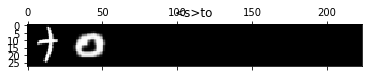

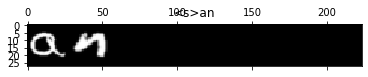

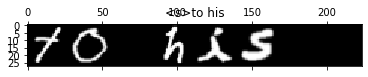

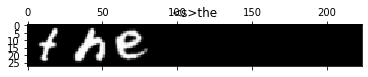

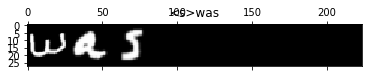

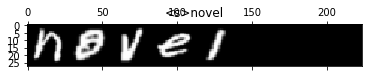

In [16]:
from text_recognizer.networks.transformer.main import run_transformer_inference


def predict_on_image(model, image, dataset):
    image = (image / 255).astype('float32')
    pred = run_transformer_inference(model, image, dataset.max_length, dataset.start_label, dataset.end_label)
    string = ''.join([dataset.mapping[ind] for ind in pred.numpy()])
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.matshow(image[0], cmap='gray')
    ax.set_title(string)
    return fig


fig = predict_on_image(model, dataset.x_train[0:1], dataset)
fig = predict_on_image(model, dataset.x_train[1:2], dataset)
fig = predict_on_image(model, dataset.x_train[2:3], dataset)
fig = predict_on_image(model, dataset.x_test[0:1], dataset)
fig = predict_on_image(model, dataset.x_test[1:2], dataset)
fig = predict_on_image(model, dataset.x_test[2:3], dataset)

## Dataset with overlap and longer sequences

In [17]:
dataset = EmnistLinesDataset(max_length=34, min_overlap=0, max_overlap=0.33, num_train=100000, num_test=10000, with_start_and_end_labels=True)
dataset.load_or_generate_data()
print(dataset)
print(dataset.x_train.shape, dataset.y_train.shape)
print(dataset.x_test.shape, dataset.y_test.shape)

EmnistLinesDataset loading data from HDF5...
EMNIST Lines Dataset
Max length: 34
Min overlap: 0
Max overlap: 0.33
Num classes: 82
Input shape: (28, 952)
Train: (100000, 28, 952) (100000, 36)
Test: (10000, 28, 952) (10000, 36)

(100000, 28, 952) (100000, 36)
(10000, 28, 952) (10000, 36)


In [18]:
train_data = DatasetSequence(dataset.x_train, dataset.y_train, batch_size=256, format_fn=format_batch)
test_data = DatasetSequence(dataset.x_test, dataset.y_test, batch_size=256, format_fn=format_batch)

In [20]:
# Let's make a beefier transfomer model

model = transformer(
    image_shape=dataset.input_shape,
    window_width=28,
    window_stride=16,
    vocab_size=len(dataset.mapping),
    num_layers=4,
    units=32,
    d_model=32,
    d_enc_outputs=32,
    num_heads=4,
    dropout=0.2,
    padding_label=dataset.padding_label)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_inputs (InputLayer)       [(None, 28, 952)]    0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, 32)     228800      image_inputs[0][0]               
__________________________________________________________________________________________________
positional_encoding_3 (Position (None, None, 32)     0           sequential_1[1][0]               
____________________________________________________________________________________________

In [21]:
learning_rate = CustomSchedule(d_model=32)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[accuracy]
)
model.fit(
    train_data,
    validation_data=test_data,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
    epochs=10
)

Epoch 1/10
391/391 [==============================] - 96s 245ms/step - loss: 2.0051 - accuracy: 0.5208 - val_loss: 1.6254 - val_accuracy: 0.5610
Epoch 2/10
391/391 [==============================] - 78s 200ms/step - loss: 1.4278 - accuracy: 0.6025 - val_loss: 1.2763 - val_accuracy: 0.6338
Epoch 3/10
391/391 [==============================] - 79s 201ms/step - loss: 1.2505 - accuracy: 0.6372 - val_loss: 1.1373 - val_accuracy: 0.6642
Epoch 4/10
391/391 [==============================] - 79s 202ms/step - loss: 1.1056 - accuracy: 0.6752 - val_loss: 0.9294 - val_accuracy: 0.7268
Epoch 5/10
391/391 [==============================] - 79s 202ms/step - loss: 0.8762 - accuracy: 0.7414 - val_loss: 0.6818 - val_accuracy: 0.8007
Epoch 6/10
391/391 [==============================] - 79s 202ms/step - loss: 0.6748 - accuracy: 0.8031 - val_loss: 0.4960 - val_accuracy: 0.8580
Epoch 7/10
391/391 [==============================] - 79s 202ms/step - loss: 0.5317 - accuracy: 0.8463 - val_loss: 0.3869 - val_ac

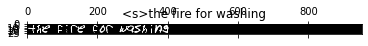

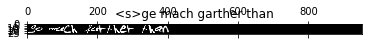

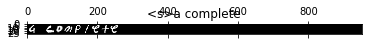

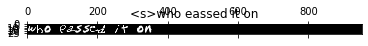

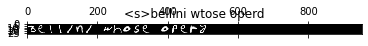

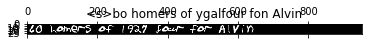

In [22]:
fig = predict_on_image(model, dataset.x_train[0:1], dataset)
fig = predict_on_image(model, dataset.x_train[1:2], dataset)
fig = predict_on_image(model, dataset.x_train[2:3], dataset)
fig = predict_on_image(model, dataset.x_test[0:1], dataset)
fig = predict_on_image(model, dataset.x_test[1:2], dataset)
fig = predict_on_image(model, dataset.x_test[2:3], dataset)